In [1]:
from amftrack.pipeline.development.high_mag_videos.kymo_class import *
from amftrack.pipeline.development.high_mag_videos.plot_data import (
    save_raw_data,
    plot_summary,
)
from scipy.signal import find_peaks
import os
from pathlib import Path
import pandas as pd
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm
from tifffile import imwrite

%matplotlib widget
%load_ext autoreload
%autoreload 2

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Welcome to the kymograph analysis pipeline module!

Use this notebook to load kymographs and extract transport flows from them. The first step is to supply some file parameters to make sure that the measurements are connected to real metrics and that the segmentation method is correct.

Important to note: 
Seg-Tresh is the limit of what percentage of the segmented image should be hypha. 

In [30]:
### Please supply a folder with kymographs. You can filter it based on the title.
### Doing that makes it easier to set image parameters for each kymo group.
### Spatial resolution should be in micrometers

img_address = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\Corentin Bisot\PC\Documents\PhD\Code\kymo\*.tiff"
out_address = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\Corentin Bisot\PC\Documents\PhD\Code\kymo\output"

# space_resolution is in micrometers per pixel,
# fps is in frames per second
# space_resolution = 4*1.725 / 50
space_resolution = 0.8625
space_resolution = 1

fps = 1
display_kymos = False

address_list = [Path(address) for address in glob(img_address)]
kymo_stack = [imageio.imread(address) for address in address_list]
kymo_edge_list = [
    KymoEdgeAnalysis(kymo=kymo, edge_name=address_list[i].stem, address=out_address)
    for i, kymo in enumerate(kymo_stack)
]

for i, kymo_anal in enumerate(tqdm(kymo_edge_list)):
    title = address_list[i].name.split(".")[-2]
    imshow_extent = [
        0,
        space_resolution * kymo_anal.kymo.shape[1],
        1 / fps * kymo_anal.kymo.shape[0],
        0,
    ]
    kymo_anal.space_pixel_size = space_resolution
    kymo_anal.time_pixel_size = 1 / fps
    forw_thresh, back_thresh = kymo_anal.fourier_kymo(1, test_plots=False)
    speeds, times = kymo_anal.extract_speeds(
        15,
        w_start=3,
        C_thresh=0.95,
        C_thresh_falloff=0.00,
        blur_size=3,
        preblur=True,
        speed_thresh=80,
    )
    flux_tot = kymo_anal.extract_transport()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.87it/s]


In [31]:
plot_summary(kymo_edge_list)
# save_raw_data(kymo_edge_list, out_address)

In [32]:
np.median(kymo_edge_list[0].speeds_tot[0][1])

5.451978

C:\Users\coren\AppData\Local\Temp\ipykernel_22100\559797244.py:13: RuntimeWarning: Mean of empty slice
  angle_plot = [np.linspace(0, np.pi, len(ftpolarimage)), np.nanmean(ftpolarimage, axis=1)]


[]
[]


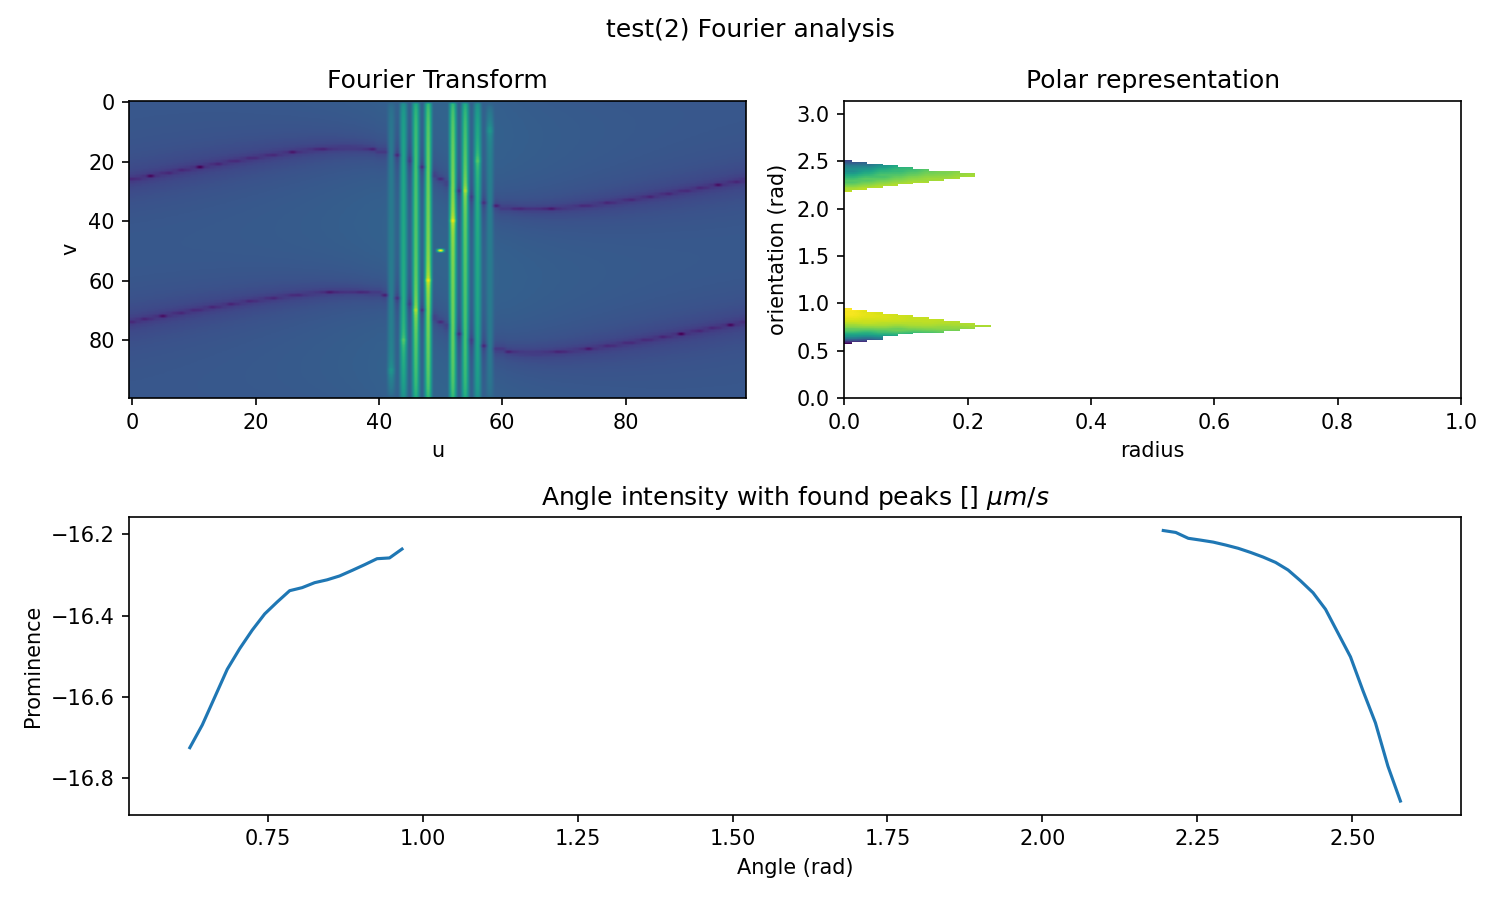

In [33]:
R = 60

plt.close("all")
for i, img in enumerate(kymo_stack):
    img_dims = np.array(img.shape)
    ftimage = np.fft.fft2(img)
    ftimage = np.fft.fftshift(ftimage)
    ftabsimage = np.log(abs(ftimage.real))
    ftpolarimage = cv2.warpPolar(
        ftabsimage,
        (-1, -1),
        (img_dims[1] / 2, img_dims[0] / 2),
        img_dims[1],
        cv2.WARP_POLAR_LINEAR + cv2.WARP_FILL_OUTLIERS,
    )
    polardims = ftpolarimage.shape
    ftpolarimage = ftpolarimage[0 : polardims[0] // 2, R : polardims[1]]
    ftpolarimage = np.where(ftpolarimage == 0, np.nan, ftpolarimage)
    angle_plot = [
        np.linspace(0, np.pi, len(ftpolarimage)),
        np.nanmean(ftpolarimage, axis=1),
    ]
    peaks, _ = find_peaks(angle_plot[1], prominence=0.35)
    speeds = (
        np.tan((angle_plot[0][peaks] - 0.5 * np.pi))
        * kymo_edge_list[i].space_pixel_size
        / kymo_edge_list[i].time_pixel_size
    )
    print(angle_plot[0][peaks])
    print(speeds)

    fig, ax = plt.subplot_mosaic(
        [["fft", "polarfft"], ["angle_plot", "angle_plot"]], figsize=(10, 6)
    )
    ax["fft"].imshow(ftabsimage, aspect="auto")
    ax["fft"].set_xlabel("u")
    ax["fft"].set_ylabel("v")
    ax["fft"].set_title("Fourier Transform")

    ax["polarfft"].imshow(ftpolarimage, aspect="auto", extent=[0, 1, 0, np.pi])
    ax["polarfft"].set_xlabel("radius")
    ax["polarfft"].set_ylabel("orientation (rad)")
    ax["polarfft"].set_title("Polar representation")

    ax["angle_plot"].plot(angle_plot[0], angle_plot[1])
    ax["angle_plot"].set_xlabel("Angle (rad)")
    ax["angle_plot"].set_ylabel("Prominence")
    ax["angle_plot"].plot(angle_plot[0][peaks], angle_plot[1][peaks], "xr")
    ax["angle_plot"].set_title(
        f"Angle intensity with found peaks {[round(speed, 4) for speed in speeds]} $\mu m / s$"
    )
    fig.suptitle(f"{kymo_edge_list[i].edge_name} Fourier analysis")
    fig.tight_layout()